In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time  # For tracking training time

# Set plot style
sns.set(style="whitegrid", palette="muted")

# 1. Load Data
df = pd.read_csv('/content/drive/MyDrive/ai-workshops/Dataset/adult.csv')

# --- CONSTRAINT: Drop 'race' feature ---
if 'race' in df.columns:
    df.drop('race', axis=1, inplace=True)
    print("Feature 'race' dropped successfully.")

# 2. Handle Missing Values ('?')
# Replace '?' with NaN first
df.replace('?', np.nan, inplace=True)

# Impute with Mode (Most Frequent Value)
# Rationale: Preserves categorical distribution without dropping data.
for col in ['workclass', 'occupation', 'native-country']:
    df[col] = df[col].fillna(df[col].mode()[0])

# 3. Remove Duplicates
initial_rows = df.shape[0]
df.drop_duplicates(inplace=True)
print(f"Duplicates removed: {initial_rows - df.shape[0]}")
print(f"Final Dataset Shape: {df.shape}")


Feature 'race' dropped successfully.
Duplicates removed: 53
Final Dataset Shape: (48789, 14)


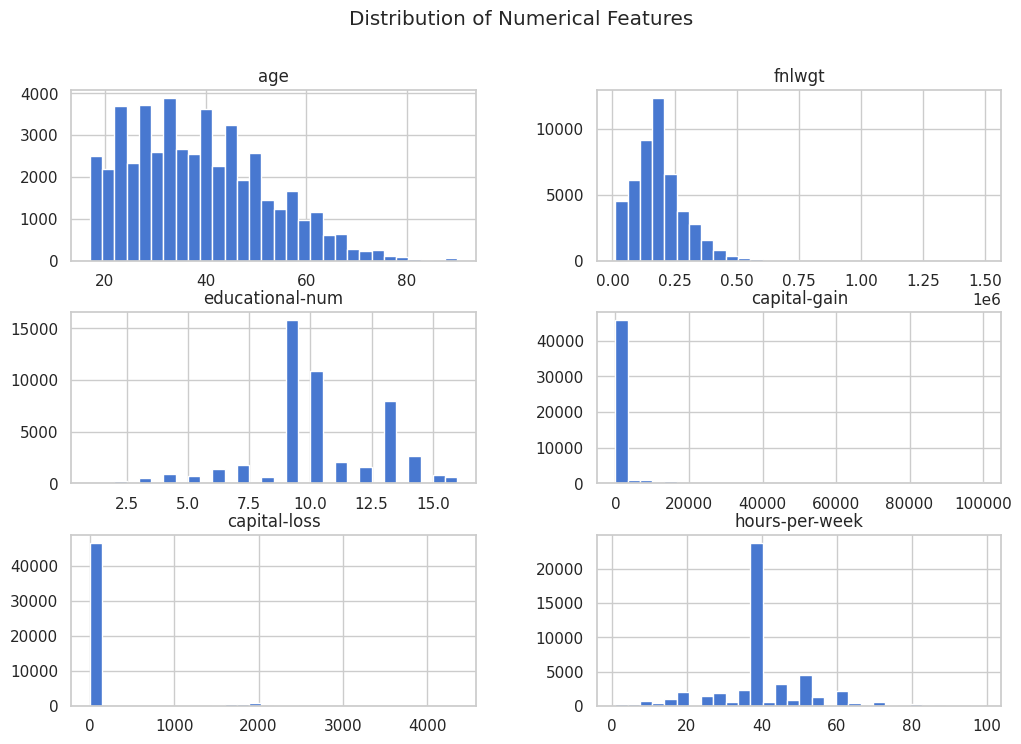

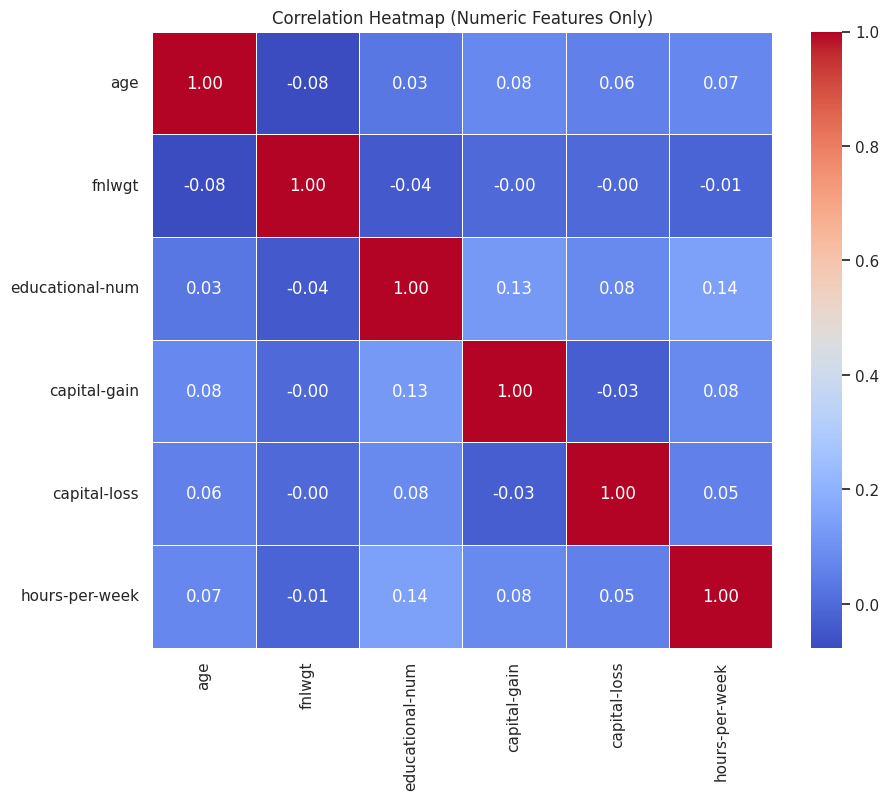

In [28]:
# 1. Univariate Analysis (Visualizing Distributions)
df.select_dtypes(include=np.number).hist(bins=30, figsize=(12, 8))
plt.suptitle("Distribution of Numerical Features")
plt.show()

# 2. Correlation Analysis (Heatmap)
# *TUTOR REQUIREMENT*: Remove categorical data first, then make heat diagram.
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap (Numeric Features Only)')
plt.show()


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 1. Split Features and Target
X = df.drop('income', axis=1)
y = df['income']

# 2. Encode Target
le = LabelEncoder()
y = le.fit_transform(y) # Maps <=50K -> 0, >50K -> 1

# 3. Encode Features (One-Hot Encoding)
# *TUTOR REQUIREMENT*: Proper preprocessing for categorical data.
# We convert categorical strings into binary columns.
X = pd.get_dummies(X, drop_first=True)

# 4. Train/Test Split (Stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 5. Scaling (Standardization)
# Essential for Neural Networks to converge.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Preprocessing Complete. Training Features: {X_train_scaled.shape[1]}")


Preprocessing Complete. Training Features: 93


In [25]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score

# 1. Define Model
mlp = MLPClassifier(hidden_layer_sizes=(64, 32),
                    activation='relu',
                    solver='adam',
                    max_iter=500,
                    random_state=42)

# 2. Train & Time
start_time = time.time()
mlp.fit(X_train_scaled, y_train)
end_time = time.time()

mlp_time = end_time - start_time
print(f"MLP Training Time: {mlp_time:.4f} seconds")

# 3. Evaluate
y_pred_mlp = mlp.predict(X_test_scaled)
mlp_f1 = f1_score(y_test, y_pred_mlp)
print(f"MLP F1-Score: {mlp_f1:.4f}")


MLP Training Time: 198.8202 seconds
MLP F1-Score: 0.6301


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Models
rf = RandomForestClassifier(random_state=42)
lr = LogisticRegression(max_iter=1000, random_state=42)

# Hyperparameter Grids
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
param_grid_lr = {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}

# --- Train Random Forest ---
print("Tuning Random Forest...")
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='f1', n_jobs=-1)

start_time = time.time()
grid_rf.fit(X_train_scaled, y_train)
end_time = time.time()

rf_time = end_time - start_time
print(f"Random Forest Training Time: {rf_time:.4f} seconds")

# --- Train Logistic Regression ---
print("Tuning Logistic Regression...")
grid_lr = GridSearchCV(lr, param_grid_lr, cv=3, scoring='f1', n_jobs=-1)

start_time = time.time()
grid_lr.fit(X_train_scaled, y_train)
end_time = time.time()

lr_time = end_time - start_time
print(f"Logistic Regression Training Time: {lr_time:.4f} seconds")

# Evaluate Best Classical Models
y_pred_rf = grid_rf.predict(X_test_scaled)
rf_f1 = f1_score(y_test, y_pred_rf)

y_pred_lr = grid_lr.predict(X_test_scaled)
lr_f1 = f1_score(y_test, y_pred_lr)


Tuning Random Forest...
Random Forest Training Time: 75.2688 seconds
Tuning Logistic Regression...
Logistic Regression Training Time: 19.6289 seconds


| Model               |   F1-Score |   Training Time (s) |
|:--------------------|-----------:|--------------------:|
| Neural Network      |   0.630058 |            198.82   |
| Random Forest       |   0.667962 |             75.2688 |
| Logistic Regression |   0.651918 |             19.6289 |


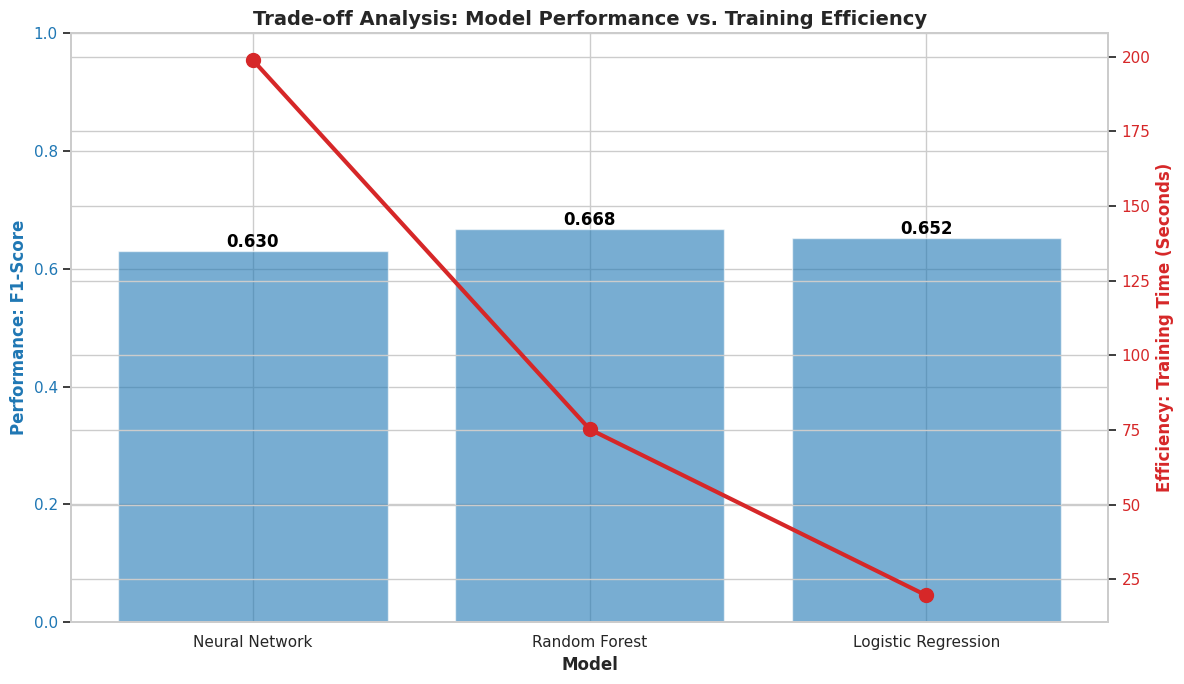


CONCLUSION:
The Logistic Regression is the most efficient, taking only 19.63s.
The Random Forest achieved the highest F1-Score of 0.6680.


In [31]:
# 1. Create Results DataFrame
results_data = {
    'Model': ['Neural Network', 'Random Forest', 'Logistic Regression'],
    'F1-Score': [mlp_f1, rf_f1, lr_f1],
    'Training Time (s)': [mlp_time, rf_time, lr_time]
}

results_df = pd.DataFrame(results_data)
print(results_df.to_markdown(index=False))

# 2. Dual-Axis Visualization
fig, ax1 = plt.subplots(figsize=(12, 7))

# Axis 1: F1-Score (Bar Chart)
color = 'tab:blue'
ax1.set_xlabel('Model', fontsize=12, fontweight='bold')
ax1.set_ylabel('Performance: F1-Score', color=color, fontsize=12, fontweight='bold')
bars = ax1.bar(results_df['Model'], results_df['F1-Score'], color=color, alpha=0.6, label='F1-Score')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 1.0) # Scale 0 to 1

# Add labels to bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}',
             ha='center', va='bottom', color='black', fontweight='bold')

# Axis 2: Training Time (Line Chart)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Efficiency: Training Time (Seconds)', color=color, fontsize=12, fontweight='bold')
ax2.plot(results_df['Model'], results_df['Training Time (s)'], color=color, marker='o',
         linewidth=3, markersize=10, label='Training Time')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Trade-off Analysis: Model Performance vs. Training Efficiency', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()

# 3. Final Conclusion
best_model = results_df.loc[results_df['F1-Score'].idxmax()]
fastest_model = results_df.loc[results_df['Training Time (s)'].idxmin()]

print(f"\nCONCLUSION:")
print(f"The {fastest_model['Model']} is the most efficient, taking only {fastest_model['Training Time (s)']:.2f}s.")
print(f"The {best_model['Model']} achieved the highest F1-Score of {best_model['F1-Score']:.4f}.")
